# History of the Supervisor-Student Relationship

The goal of this project is to analyze famous supervisor-student relationships with data scrapped from the Wikipedia. I intend to figure out who can be considered the best supervisors in history, those whose supervised students that ended up supervising more (and so on).

The code for scrapping the Wikipedia is available at `scraper.py` and it uses as seed a pool of relevant people (i.e. Nobel prize laureates, Turing award winners etc) which can be found in `seed.json`. The data collected has been cleaned and it's ready to be used. I haven't published the dataset yet, since I want to further improve it, but contact me if you want it.

In [1]:
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
from operator import itemgetter
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [2]:
# Load csv with all relationships
supervision_df = pd.read_csv('relations.csv')
supervision_df.reset_index(drop=True, inplace=True)
supervision_df.head()

,supervisor,student
0,A. Carl Helmholz,Kent Terwilliger
1,A. Carl Helmholz,Lawrence W. Jones
2,A. Carl Helmholz,Barry Barish
3,A. David Buckingham,Brian Orr
4,A. David Buckingham,Laurence D. Barron


First, let's find out a few numbers about the dataset.

In [3]:
unique_people = len(set(supervision_df.student.tolist() + supervision_df.supervisor.tolist()))
print('The total number of unique people in the dataset is {}'.format(unique_people))

The total number of unique people in the dataset is 7070


In [4]:
unique_students = len(supervision_df.student.unique())
print('The total number of unique students in the dataset is {}'.format(unique_students))

The total number of unique students in the dataset is 6517


In [5]:
unique_supervisors = len(supervision_df.supervisor.unique())
print('The total number of unique supervisors in the dataset is {}'.format(unique_supervisors))

The total number of unique supervisors in the dataset is 2862


The obvious structure for these supervisor-student relationships is a **graph**. However, it could be an undirected or directed graph. I think both graphs make sense in their own way, so I'll explore both and explain why.

## 1. Undirected Graph

A graph is undirected if all the edges are bidirectional. At first sight, it makes more sense to create a directed graph since the relationship at hand is unidirectional. Nonetheless, analyzing an undirected graph gives interesting results because it considers as important to be a supervisor than a student.

In [6]:
# Create graph using a Pandas dataframe
graph = nx.from_pandas_edgelist(supervision_df, 'supervisor', 'student', edge_attr=None, create_using = nx.Graph())
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 7070
Number of edges: 8071
Average degree:   2.2832


On average, most people only have a supervisor and a student

### 1.1 Density

The density $\mathcal{D} \in [0,1]$ of a graph represents the number of edges in proportion to the number of nodes. A dense graph is such where the number of edges is close to the maximum possible.

In [7]:
print("Graph density: %.4f" %nx.density(graph))

Graph density: 0.0003


As we can see, the graph is sparse, which means we don't have many edges.

### 1.2 Components

A connected component in a graph is a subgraph where all vertices are reachable from each other.

In [8]:
components = list(nx.connected_components(graph))
print('The graph contains', len(components), 'connected components')

The graph contains 84 connected components


In [9]:
largest_comp = max(components, key=len)
percentage_lc = len(largest_comp)/ graph.number_of_nodes() * 100
print('The largest component has ', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lc, '% of the nodes')

The largest component has  6774 nodes accounting for 95.81 % of the nodes


In [10]:
# Save largest component graph for later
lc_graph = graph.subgraph(largest_comp)

Our graph has 84 connected components, but one accounts for 95.81% of the total size. This already is quite impressive, since we started from a pool of people from different fields (e.g. chemistry and computer science). This shows how mathematics has divided into more specific fields such as physics, economics etc. The forefathers, as we'll see, are common to every field.

### 1.3 Diameter

The diameter of a graph is the maximum eccentricity of any node in the graph. The eccentricity of a node $v$ is the maximum distance from node $v$ to any other node in the graph.

In [11]:
# WARNING: It is computationally expensive
# Diameter of the largest connected component of the graph
diameter = nx.diameter(lc_graph)
print("The diameter of the largest component is", diameter)

The diameter of the largest component is 37


### 1.4 Degree

The degree of a node $v$ in an undirected graph is the number of edges that connects $v$ with other nodes. Let's find out who are the people with the most connections (either students or supervisors).

In [12]:
degrees = dict(graph.degree(graph.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# Print top
for i, (person, degree) in enumerate(sorted_degree[:15]):
    print(i+1, person, ' is related to ', degree, ' people')

1 Arnold Sommerfeld  is related to  44  people
2 David Hilbert  is related to  37  people
3 Dimitris Bertsimas  is related to  34  people
4 Robert Solow  is related to  30  people
5 Max Born  is related to  29  people
6 Felix Klein  is related to  28  people
7 Alonzo Church  is related to  27  people
8 Franz Boas  is related to  27  people
9 Abdus Salam  is related to  25  people
10 J. J. Thomson  is related to  24  people
11 John Archibald Wheeler  is related to  23  people
12 Justus Liebig  is related to  23  people
13 Walther Nernst  is related to  22  people
14 Robert Bunsen  is related to  22  people
15 Karl Weierstrass  is related to  21  people


This list is already pretty interesting, containing some of the greatest which will appear again. The following figure shows a plot of the degree of a node and the number of nodes with such a degree.

Text(0.5, 1.0, 'Degree distribution for the graph')

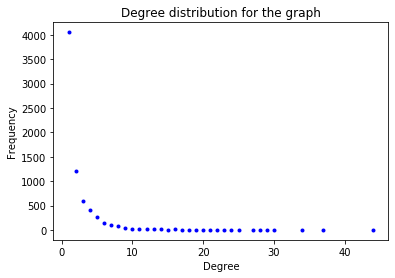

In [13]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict(degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markeredgecolor='none', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the graph')

As we can observe, the relationships follow a power law distribution since most people only have few connections and a few people have a lot of connections. Arnold Sommerfeld is the winner by an important margin, and we will see why shortly.

### 1.5 Betweenness Centrality

Betweenness centrality is a good way of measuring how important are the nodes in the graph. It measures the centrality of a node $v$, as the proportion of shortest paths from all pairs of nodes that pass through $v$. If a node finds itself in between the path connecting other nodes then it is essential for that connection. The following list represents the top nodes based on this metric

In [14]:
# WARNING: It's computationally expensive
betweenness = nx.betweenness_centrality(graph)
# Assign each to an attribute in your network
nx.set_node_attributes(graph, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for i, (person, bw) in enumerate(sorted_betweenness[:15]):
    print(i+1, person, ' has betweeness centrality: %.3f' %bw)

1 David Hilbert  has betweeness centrality: 0.159
2 Max Born  has betweeness centrality: 0.152
3 Hans Reichenbach  has betweeness centrality: 0.121
4 Arnold Sommerfeld  has betweeness centrality: 0.120
5 Hermann Helmholtz  has betweeness centrality: 0.085
6 E. H. Moore  has betweeness centrality: 0.073
7 J. J. Thomson  has betweeness centrality: 0.071
8 Solomon Lefschetz  has betweeness centrality: 0.070
9 John von Neumann  has betweeness centrality: 0.058
10 Ludwig Boltzmann  has betweeness centrality: 0.055
11 Gustav Kirchhoff  has betweeness centrality: 0.052
12 Max Planck  has betweeness centrality: 0.051
13 Hubert Newton  has betweeness centrality: 0.051
14 Ferdinand von Lindemann  has betweeness centrality: 0.049
15 Arthur W. Wright  has betweeness centrality: 0.044


The prize goes to David Hilbert. The people appearing in this list makes a lot of sense with some pre-knowledge of history. They are all from the 20th century, which follows from using an undirected graph and considering connections in both ways. Therefore, important nodes are in the center of the graph, after the "founders" of current mathematics (i.e. Lagrange, Euler, Gauss...) and before current people at the forefront of these fields.

In the list we can find David Hilbert, a crucial connection to the greatest mathematicians of the 20th century. Similarly, we find Max Born, which satisfies a similar role for the physicists of the 20th century. In a similar sport than Max Born is Hermann Helmholtz. We can also find Solomon Lefschetz, who supervised people such as John McCarthy (computer science) and John Tukey (statistics). Most of the other people in the list are related to the other.

### 1.6 Eigenvector Centrality

Eigenvector centrality is a different way of measuring centrality. However, in this case the importance of a node increases if it is related to another important node. This is similar to the PageRank algorithm used by Google.

In [15]:
eigenvector_centrality = nx.eigenvector_centrality(graph)
# Assign each to an attribute in your network
nx.set_node_attributes(graph, eigenvector_centrality, 'eigenvector_centrality')
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=itemgetter(1), reverse=True)

for i, (person, ec) in enumerate(sorted_eigenvector_centrality[:15]):
    print(i+1, person, ' has eigenvector centrality: %.3f' %ec)

1 Arnold Sommerfeld  has eigenvector centrality: 0.578
2 Max Born  has eigenvector centrality: 0.214
3 Werner Heisenberg  has eigenvector centrality: 0.213
4 Wolfgang Pauli  has eigenvector centrality: 0.162
5 Hans Reichenbach  has eigenvector centrality: 0.158
6 Rudolph E. Peierls  has eigenvector centrality: 0.154
7 David Hilbert  has eigenvector centrality: 0.140
8 Ferdinand von Lindemann  has eigenvector centrality: 0.119
9 Gregor Wentzel  has eigenvector centrality: 0.110
10 Linus Pauling  has eigenvector centrality: 0.109
11 William V. Houston  has eigenvector centrality: 0.109
12 Hans Bethe  has eigenvector centrality: 0.105
13 J. J. Thomson  has eigenvector centrality: 0.103
14 Walter Heitler  has eigenvector centrality: 0.102
15 Fritz Sauter  has eigenvector centrality: 0.099


The winner is Arnold Sommerfeld, who served as doctoral supervisor for many Nobel Prize winners in physics and chemistry. In particular, he supervised 5 future Nobel Prize winners such as Werner Heisenberg, Wolfgang Pauli, Peter Debye, Hans Bethe, Linus Pauling, Isidor I. Rabi and Max von Laue.

This is no surprise since Arnold Sommerfeld is arguably once of the greatest supervisors in history. Einstein admired Sommerfeld's ability to find young talent. Sommerfeld's style as a professor invited collaboration from his students. He met with them at home or in cafes. He also shared his alpine ski hut with students, where they would meet for discussions of physics.

It is fascinating that with this measure of centrality we can find the importance of Arnold Sommerfeld without knowing anything about their students, just based on the number of connections and descendants. Most of the people on the list are directly related to Arnold Sommerfeld.

On the other hand, we find Max Born again, and we can find that some of his students (Max Delbrück, Maria Goeppert Mayer and Enrico Fermi) are also Nobel Prize winners.

It is surprising to see J. J. Thomson so low on the list, since he was a Nobel Prize winner himself and another eight Nobel Prize winners were supervised by him: Charles Glover Barkla, Charles Thomson Rees Wilson, Ernest Rutherford, Francis William Aston, William Henry Bragg, Max Born, Niels Bohr and George Paget Thomson.

### 1.7 Bridges

A bridge edge in a graph is an edge that disconnects a graph when removed. A node with many bridge edges represents a person that is crucial to connect one part of the graph with another branch.

In [16]:
pd.DataFrame(list(nx.bridges(graph))).rename(columns={0: 'src', 1: 'dst'}).groupby('src').count().sort_values(by='dst', ascending=False).reset_index().rename(columns={'src': 'person', 'dst': 'bridges'}).head(15)

,person,bridges
0,Dimitris Bertsimas,32
1,Franz Boas,25
2,Robert Solow,21
3,Arnold Sommerfeld,19
4,Alonzo Church,19
5,David Hilbert,18
6,John Archibald Wheeler,16
7,Felix Klein,15
8,Salomon Bochner,14
9,Garrett Birkhoff,13


There are some familiar people in the list which have appeared before: Arnold Sommerfeld, David Hilbert, Felix Klein... However, there are new faces which are very interesting.

Dimitris Bertsimas could be considered an outlier, because his Wikipedia page lists all of his doctoral students, which is not usually the case for all the others. In general, the only relationships that appear are the ones where both sides have a Wikipedia page. However, all of the students in Bertsimas' list do not have a Wikipedia page.

Franz Boas is very interesting. He was an anthropologist who supervised many students, becoming the backbone for that community in our graph. At first, it surprised that an anthropologist is among the people on this dataset. However, we trace Franz Boas back to Abraham Gotthelf Kästner, and from him down to Carl Gustav Jacob Jacobi.

In [17]:
path = nx.shortest_path(graph, source="Franz Boas", target="Abraham Gotthelf Kästner")
print("Shortest path:", path)

Shortest path: ['Franz Boas', 'Rudolf Virchow', 'Johannes Peter Müller', 'Karl Rudolphi', 'Christian Ehrenfried Weigel', 'Johann Christian Polycarp Erxleben', 'Abraham Gotthelf Kästner']


In [18]:
path = nx.shortest_path(graph, source="Abraham Gotthelf Kästner", target="Carl Gustav Jacob Jacobi")
print("Shortest path:", path)

Shortest path: ['Abraham Gotthelf Kästner', 'Johann Tobias Mayer', 'Enno Dirksen', 'Carl Gustav Jacob Jacobi']


Similarly to Franz Boas, Robert Solow is connected to a community of economists and his ancestors are mathematicians. Others like Alonzo Church, Richard Karp or Marvin Minsky are crucial connections between the fields of mathematics and computer science. At the end of the list we find Noam Chomsky, a connection between mathematics and linguists.

## 2. Directed Graph

A graph is directed if all the edges are unidirectional. In this case, supervision is more important than being a student.

In [19]:
# Create digraph using a Pandas dataframe
digraph = nx.from_pandas_edgelist(supervision_df, 'supervisor', 'student', edge_attr=None, create_using = nx.DiGraph())
print(nx.info(digraph))

Name: 
Type: DiGraph
Number of nodes: 7070
Number of edges: 8071
Average in degree:   1.1416
Average out degree:   1.1416


### 2.1 Betweenness Centrality

Betweenness centrality is a good way of measuring how important are the nodes in the graph. It measures the centrality of a node $v$, as the proportion of shortest paths from all pairs of nodes that pass through $v$. If a node finds itself in between the path connecting other nodes then it is essential for that connection. The following list represents the top nodes based on this metric.

The main difference compared to the results in Section 1.6 is that in this case paths can only be calculated in the direction of supervisor to student. Therefore, it is expected to find that the nodes at the top of the tree will be found more often in shorted paths down the tree.

In [20]:
betweenness = nx.betweenness_centrality(digraph)
# Assign each to an attribute in your network
nx.set_node_attributes(digraph, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for i, (person, bw) in enumerate(sorted_betweenness[:15]):
    print(i+1, person, ' has betweeness centrality: %.3f' %bw)

1 Joseph-Louis Lagrange  has betweeness centrality: 0.002
2 Leonhard Euler  has betweeness centrality: 0.002
3 Johann Bernoulli  has betweeness centrality: 0.002
4 Siméon Poisson  has betweeness centrality: 0.001
5 Felix Klein  has betweeness centrality: 0.001
6 Peter Dirichlet  has betweeness centrality: 0.001
7 Nikolaus Eglinger  has betweeness centrality: 0.001
8 Emmanuel Stupanus  has betweeness centrality: 0.001
9 Rudolf Lipschitz  has betweeness centrality: 0.001
10 Ferdinand von Lindemann  has betweeness centrality: 0.001
11 Carl Gauss  has betweeness centrality: 0.001
12 Johann Pfaff  has betweeness centrality: 0.001
13 Petrus Ryff  has betweeness centrality: 0.001
14 Michel Chasles  has betweeness centrality: 0.001
15 Theodor Zwinger  has betweeness centrality: 0.001


The winner is Lagrange, and we can find many of the forefathers of mathematics. Since we use a directed graph, we value more the supervisors, and therefore we end up with the greatest mathematicians.

Lagrange supervised people such as Fourier and Poisson. Euler supervised Lagrange, and was supervised by Johann Bernoulli. Felix Klein was supervised by Lipschitz, and supervised many great mathematicians. Among others, Klein supervised Ferdinand von Lindemann who supervised David Hilbert and Arnold Sommerfeld, coming full circle.

See Section 2.3 to see an interesting path between Lagrange and John von Neumann.

### 2.2 Eccentricity

The eccentricity of a node $v$ is the maximum distance from node $v$ to any other node in the graph. However, in a directed graph it's not possible to calculate it when the graph is not strongly connected (i.e. all nodes are reachable between each other). Nevertheless, I'm only interested in the nodes with the maximum eccentricity, so I define a weak eccentricity (because our directed graph is weakly connected) where an unreachable node is at a distance of zero. This is a great measure to find the people at the top of the tree.

In [21]:
def weak_eccentricity(G):
    # Exaclty like eccentricity, but when a node is unreachable
    # the distance is 0. This is only worth to use the max
    # eccentricity which otherwise is not possible on a
    # weakly connected directed graph
    order=G.order()

    e={}
    for n in G.nbunch_iter(None):
        length=nx.single_source_shortest_path_length(G,n)
        L = len(length)
        if L != order:
            L = 0
            
        e[n]=max(length.values())

    return e

Now we can calculate the weak eccentricity for every node in the graph and list the top nodes in decreasing order.

In [22]:
eccentricity = weak_eccentricity(digraph)
# Assign each to an attribute in your network
nx.set_node_attributes(digraph, eccentricity, 'eccentricity')
sorted_eccentricity = sorted(eccentricity.items(), key=itemgetter(1), reverse=True)

for i, (person, ecc) in enumerate(sorted_eccentricity[:15]):
    print(i+1, person, ' has eccentricity: %d' %ecc)

1 Marco Musuro  has eccentricity: 26
2 Nicoletto Vernia  has eccentricity: 26
3 Ognibene da Lonigo  has eccentricity: 26
4 Pietro Roccabonella  has eccentricity: 26
5 Giovanni Battista della Monte  has eccentricity: 25
6 Giovanni Manardo  has eccentricity: 25
7 Johannes Baptista Montanus  has eccentricity: 25
8 Niccolò Leoniceno  has eccentricity: 25
9 Pietro Pomponazzi  has eccentricity: 25
10 Antonio Musa Brassavola  has eccentricity: 24
11 Bassiano Landi  has eccentricity: 24
12 Petrus Ramus  has eccentricity: 24
13 Vittore Trincavelli  has eccentricity: 24
14 Thomas Platter  has eccentricity: 24
15 Gabriele Falloppio  has eccentricity: 23


Personally, I think the people on this list are not that famous, but they are the top of the tree and have the greatest among their descendants.

For instance, we can calculate the eccentricity of one of the greatest as follows

In [23]:
node = 'Joseph-Louis Lagrange'
ecc = dict(sorted_eccentricity)[node]
print('The eccentricity of {} is {}'.format(node, ecc))

The eccentricity of Joseph-Louis Lagrange is 17


### 2.3 Paths

Let's find some of the shortest paths from one person to another (if exists).

In [24]:
path = nx.shortest_path(digraph, source="Joseph-Louis Lagrange", target="John von Neumann")
print("Shortest path:", path)

Shortest path: ['Joseph-Louis Lagrange', 'Joseph Fourier', 'Peter Dirichlet', 'Rudolf Lipschitz', 'Felix Klein', 'Ferdinand von Lindemann', 'David Hilbert', 'John von Neumann']


What a remarkable path from Lagrange to Neumann.

### 2.4 Draw Tree

It is interesting to draw the tree of influences of a person.

In [25]:
# This function returns the subgraph starting from a root node, obtaining the supervisors and students recursively
def subgraph(G, root_node, levels=1):
    nodes = [[root_node]]
    subgraph_nodes = [root_node]
    # Empty lists are False
    while levels > 0 and nodes:
        levels -= 1
        level_nodes = nodes.pop(0)
        new_level_nodes = []
        for n in level_nodes:
            students = list(digraph.neighbors(n))
            advisors = list(digraph.predecessors(n))
            new_level_nodes = new_level_nodes + students + advisors
            subgraph_nodes = subgraph_nodes + students + advisors
        nodes += [new_level_nodes]

    return G.subgraph(subgraph_nodes)

In [26]:
sub_digraph = subgraph(digraph, 'David Hilbert', levels=2)

In [27]:
write_dot(sub_digraph, "hilbert.dot")

In [28]:
!unflatten -l 12 hilbert.dot | dot -Tsvg -o hilbert.svg
!rm hilbert.dot

### 2.5 Draw Tree Connecting Pool of People

Now, we focus on drawing the tree given a pool of people, with all the necessary nodes that connect them (if feasible).

In [29]:
def pool_subgraph(G, DG, root_nodes):
    subgraph_nodes = []
    for n1 in root_nodes:
        for n2 in root_nodes:
            if n1 != n2:
                try:
                    path = nx.shortest_path(G, source=n1, target=n2)
                    subgraph_nodes += path
                except nx.NetworkXNoPath:
                    None

    return DG.subgraph(subgraph_nodes)

In [30]:
pool = ['Leonhard Euler', 'David Hilbert', 'Siméon Poisson', 'Pierre-Simon Laplace', 'Karl Weierstrass']
pool_digraph = pool_subgraph(graph, digraph, pool)

In [31]:
write_dot(pool_digraph, "pool.dot")

In [32]:
!unflatten -l 12 pool.dot | dot -Tsvg -o pool.svg
!rm pool.dot

## Future Work

- For each person set attributes such as field, birthday, gender, prizes etc
- Find if there are communities that actually map to different fields. I imagine that at the beginning everyone is pretty much connected and a mathematician, but then some fields are branches of some particular people.
- Study homophily, how likely two people that have the same attribute are linked.
- Print a tree .dot with the greatest people in the tree and their connections
- Replicate the study with the data from the Mathematics Genealogy Project